In [1]:
import numpy as np
import tensorflow
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
import os 
import pandas as pd

2024-01-06 11:23:24.113584: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-06 11:23:24.447824: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 11:23:24.447891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 11:23:24.449051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 11:23:24.577231: I tensorflow/core/platform/cpu_feature_g

## Data Loading

In [2]:
# Data set used to train GAT model
x=np.load('../BraiNeoCare/Datasets/GAT/zenodo_data_consensus_4s_GAT.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/GAT/zenodo_labels_consensus_4s_GAT.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,)

y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32) 

In [11]:
x_train=np.load('../BraiNeoCare/Datasets/balanced_x_train_common_4s.npy', mmap_mode='r')
x_test=np.load('../BraiNeoCare/Datasets/balanced_x_test_common_4s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare/Datasets/balanced_y_train_common_4s.npy', mmap_mode='r')
y_test=np.load('../BraiNeoCare/Datasets/balanced_y_test_common_4s.npy', mmap_mode='r')

In [3]:
mean=x_train.mean()
std=x_train.std()
x_train=((x_train-mean)/std).reshape(x_train.shape[0],384,12)
x_test=((x_test-mean)/std).reshape(x_test.shape[0],384,12)

In [4]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],384,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],384,12)
y_test = y_test[test_indices]

In [ ]:
# x_train=x_train*(10**5)
# x_test=x_test*(10**5)

## Tiny model

In [11]:
'''For 4s partitions I used dropout=0.25, and learning rate=0.0025, and weight decay=0.01. Saved model is best_model_for_4s_1.h5 was taken
after 500 epoch with batch size=128'''

Input=keras.Input(shape=(384,12),name="Input_signal")
x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
a=layers.add([x,y])
x=layers.MaxPooling1D(4)(a)
x=layers.SpatialDropout1D(0.25)(x) 

x=layers.Conv1D(128,3,padding="same",activation='swish')(x)
y=layers.SpatialDropout1D(0.25)(x)#new   
y=layers.Conv1D(128,5,padding='same',activation='swish')(y)#new
a=layers.add([x,y])#new

x=layers.GlobalAveragePooling1D()(a)
x=layers.Dropout(0.25)(x)
x=layers.Dense(32,activation='swish')(x) 
x=layers.Dropout(0.25)(x)
x=layers.Dense(16,activation='swish')(x)
x=layers.Dense(1,activation='sigmoid')(x)

model1=keras.Model(inputs=Input,outputs=x)

optimizer=keras.optimizers.Adam(learning_rate=0.0025,weight_decay=0.01)
loss=keras.losses.BinaryCrossentropy(from_logits=False)#,alpha=0.9,apply_class_balancing=True)

F1=keras.metrics.F1Score(threshold=0.5, name='F1', dtype=None) 
precall = keras.metrics.Precision()
recall = keras.metrics.Recall()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer=optimizer,loss=loss,metrics=['accuracy',F1, AUROC, AUPRC, precall, recall])

In [12]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_signal (InputLayer)   [(None, 384, 12)]            0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 384, 32)              1184      ['Input_signal[0][0]']        
                                                                                                  
 conv1d_5 (Conv1D)           (None, 384, 32)              1952      ['Input_signal[0][0]']        
                                                                                                  
 add_2 (Add)                 (None, 384, 32)              0         ['conv1d_4[0][0]',            
                                                                     'conv1d_5[0][0]']      

In [5]:
checkpoint_path='Saved_model_weights_11/cp_{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max',)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,monitor="val_accuracy",save_weights_only=False,verbose=0,save_best_only=True)
# def lrschedule(epoch,lr):
#     if (epoch%50==0 and epoch!=0):
#         return lr*0.9
#     else:
#         return lr
# LRscheduler=LearningRateScheduler(lrschedule,verbose=0) w

history=model1.fit(x_train,y_train,epochs=1000,batch_size=256,validation_data=(x_test,y_test),callbacks=[cp_callback])

In [ ]:
model=keras.models.load_model('Saved_model_weights_4/cp_0194.ckpt/')
model.evaluate(x_test,y_test) 

In [16]:
model1.save('best_model_for_4s.h5')

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
with open("history_for_4s_best.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

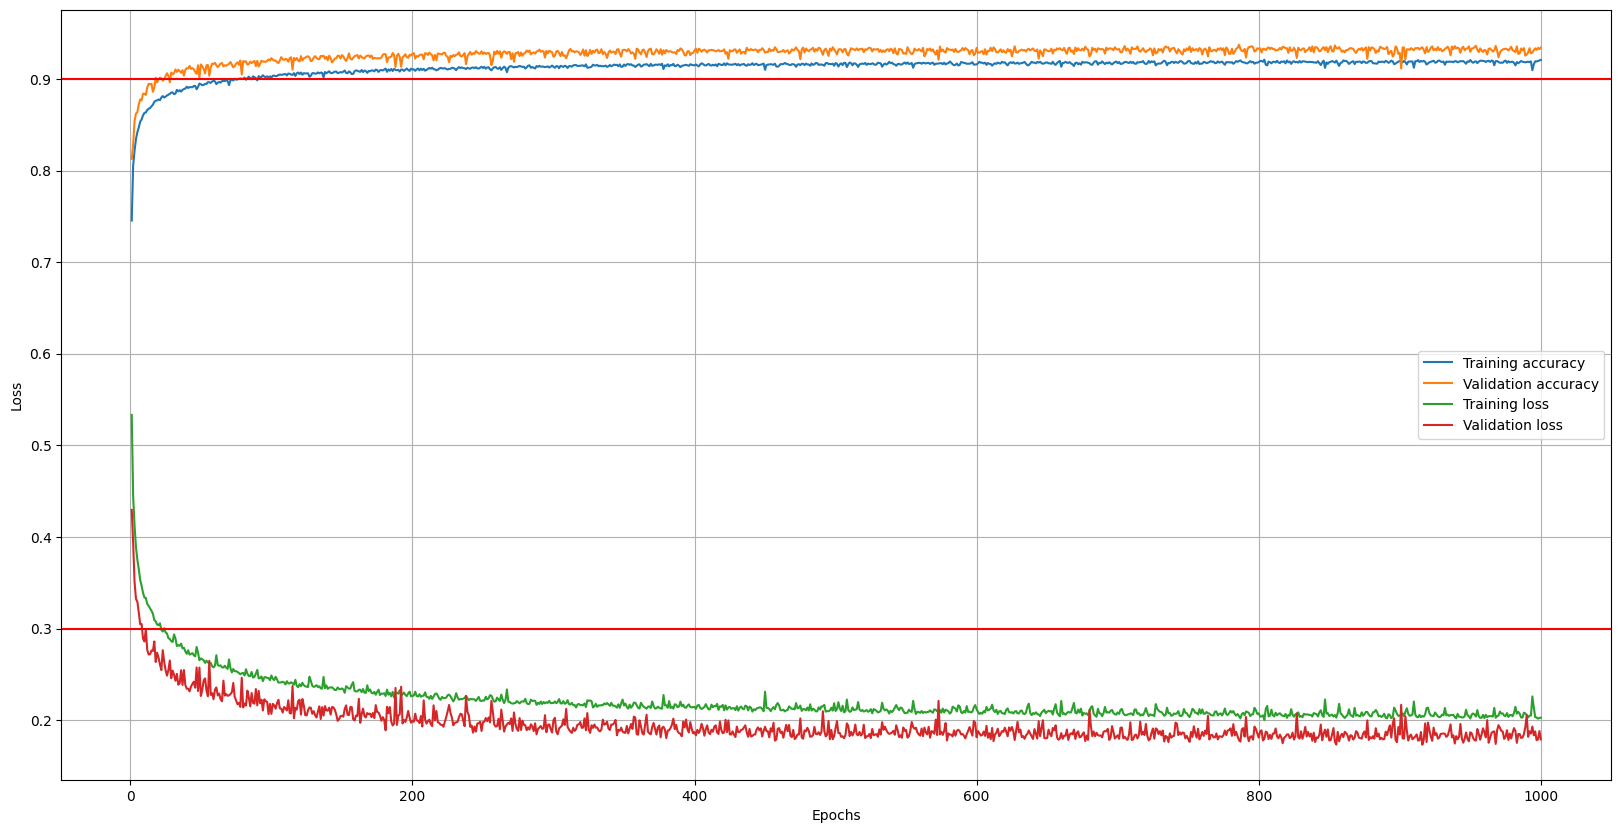

In [15]:
# Plot the training and validation loss and accuracy for each epoch for 1s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.axhline(y=0.3, color='r', linestyle='-')

plt.grid()
# plt.ylim(0,1)
# plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

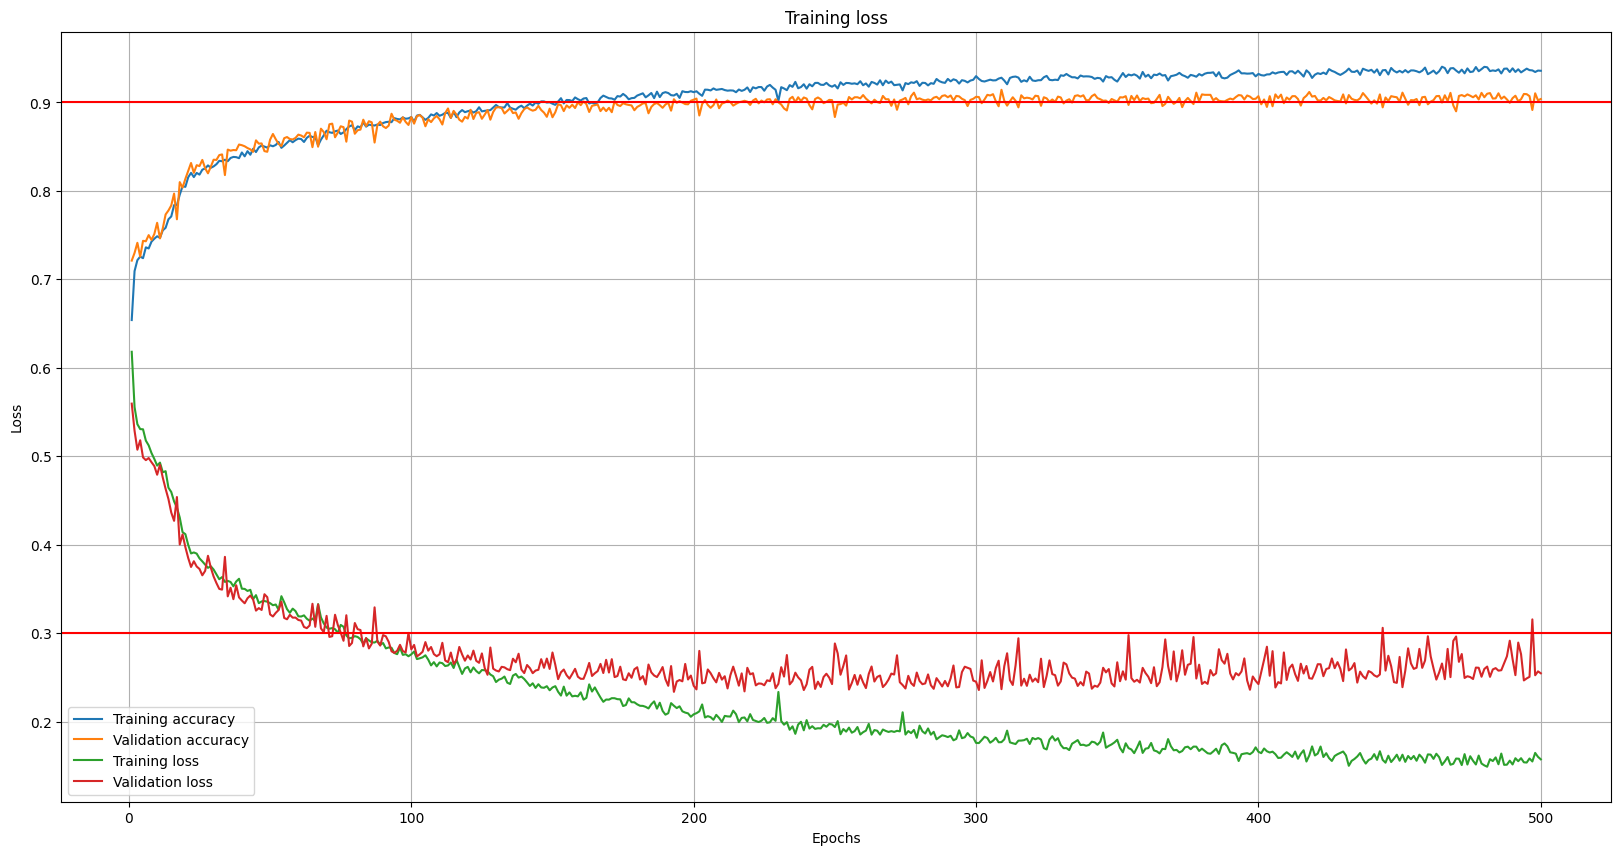

In [39]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_for_4s_best.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.axhline(y=0.3, color='r', linestyle='-')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
model=keras.models.load_model('./Saved_model_weights_11/cp_0786.ckpt/')
model.evaluate(x_test,y_test)

2024-01-06 11:25:39.800485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-01-06 11:25:39.801080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-01-06 11:25:42.962223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


809/809 [==============================] - 11s 9ms/step - loss: 0.1783 - accuracy: 0.9373 - F1: 0.9005 - AUROC: 0.9763 - AUPRC: 0.9646 - precision_1: 0.9321 - recall_1: 0.8709


[0.17828936874866486,
 0.937318742275238,
 array([0.9004972], dtype=float32),
 0.9763466715812683,
 0.9646478891372681,
 0.9321388006210327,
 0.8709332942962646]